In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rnd

In [2]:
csv_path = '..\data\_approach_1.csv'
df = pd.read_csv(csv_path)
df.head()

,time_stamp,date_time,volume_per_hour,speed_kmh,travel_time,free_flow_travel_time,usual_delay_sec,delay_sec
0,1576796430000,20/12/2019 00:01:00,388,12.250033,61,35,-1,26
1,1576796490000,20/12/2019 00:02:00,388,14.652000,51,35,-1,16
2,1576796550001,20/12/2019 00:03:00,388,13.586401,55,35,-1,20
3,1576796610000,20/12/2019 00:04:00,388,13.586401,55,35,-1,20
4,1576796670000,20/12/2019 00:05:00,388,13.586401,55,35,-1,20


In [3]:
df.volume_per_hour = df.loc[:,"volume_per_hour"].replace(to_replace=0, method='ffill')
df.speed_kmh = df.loc[:,"speed_kmh"].replace(to_replace=0, method='ffill')
df.travel_time = df.loc[:,"travel_time"].replace(to_replace=0, method='ffill')
df.loc[df.volume_per_hour > 1800, "volume_per_hour"] = 1800

In [4]:
def aggregate_df(df, begin_time_stamp, aggregate_time, aggregate_steps):
    five_min_speed_aggr = []
    five_min_vol_aggr = []
    five_min_tt_aggr = []
    mean_vol = df.volume_per_hour.mean()
    mean_speed = df.speed_kmh.mean()
    mean_travel_time = df.travel_time.mean()

    date_list = []
    timestamp_list = []
    for i in range(0, aggregate_steps):
        five_min_result = df.loc[
            (df.time_stamp >= begin_time_stamp) & (df.time_stamp <= begin_time_stamp + aggregate_time)]
        five_min_count = five_min_result.shape[0]
        timestamp_list.append(begin_time_stamp + aggregate_time)
        if five_min_count > 0:
            five_min_vol_aggr.append(five_min_result.volume_per_hour.mean())
            five_min_speed_aggr.append(five_min_result.speed_kmh.mean())
            five_min_tt_aggr.append(five_min_result.travel_time.mean())
            date_list.append(five_min_result.iloc[five_min_count - 1].date_time)
        else:
            five_min_vol_aggr.append(mean_vol * rnd.uniform(0.5, 1.5))
            five_min_speed_aggr.append(mean_speed * rnd.uniform(0.5, 1.5))
            five_min_tt_aggr.append(mean_travel_time * rnd.uniform(0.5, 1.5)) 

        begin_time_stamp = begin_time_stamp + aggregate_time

    return timestamp_list, five_min_vol_aggr, five_min_speed_aggr, five_min_tt_aggr

In [5]:
start_timestamp = 1576796429000
five_min_tuples = aggregate_df(df, start_timestamp, 300000, 25422)

In [6]:
label_path = '..\data\MeasuremetStations30050.rpt'
measures = pd.read_fwf(label_path, skiprows=[1], nrows=25422)
measures.loc[:,"Vehicles"].replace(to_replace=0, method='ffill')
measures.loc[measures["Vehicles"] > 1800 , ["Vehicles"]] =  1800

labels = measures["Vehicles"]
labels = labels * 12
labels.index = measures["MeasurementStationID Timestamp"]


In [7]:
aggr_tuples = list(zip(five_min_tuples[0], five_min_tuples[1], five_min_tuples[2], five_min_tuples[3],
                       labels))
    
aggr_df = pd.DataFrame(aggr_tuples,
                           columns=["timestamp", "volume_per_hour", "speed_kmh", "travel_time", "vehicle_count"])

In [8]:
aggr_df.shape

(25422, 5)

In [9]:
aggr_df.head()

,timestamp,volume_per_hour,speed_kmh,travel_time,vehicle_count
0,1576796729000,388.0,13.532247,55.4,528
1,1576797029000,601.4,15.737581,47.8,432
2,1576797329000,737.2,16.932894,44.2,504
3,1576797629000,950.6,17.629972,42.4,444
4,1576797929000,698.4,16.101206,46.6,432


In [10]:
features_considered = ['volume_per_hour', 'speed_kmh', 'travel_time', 'vehicle_count']
features = aggr_df[features_considered]
features.index = aggr_df['timestamp']
features.head()


,volume_per_hour,speed_kmh,travel_time,vehicle_count
timestamp,,,,
1576796729000,388.0,13.532247,55.4,528
1576797029000,601.4,15.737581,47.8,432
1576797329000,737.2,16.932894,44.2,504
1576797629000,950.6,17.629972,42.4,444
1576797929000,698.4,16.101206,46.6,432


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F986A88D08>,
      dtype=object)

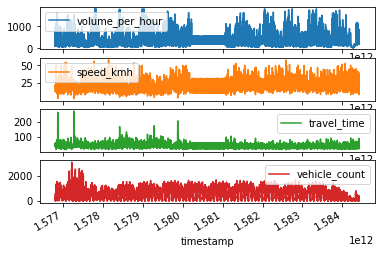

In [11]:
features.plot(subplots=True)

In [12]:
labels.tail()

MeasurementStationID Timestamp
2020-03-17 06:30:00    276
2020-03-17 06:35:00    264
2020-03-17 06:40:00    336
2020-03-17 06:45:00    396
2020-03-17 06:50:00    312
Name: Vehicles, dtype: int64

In [13]:
def normalize_dataset(data, data_mean, data_std):    
    return (data-data_mean)/data_std
    

In [14]:
def denormalize_data(data, data_mean, data_std):
    return (data * data_std) + data_mean
    

In [15]:
TRAIN_SPLIT = 20000

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = normalize_dataset(dataset, data_mean,data_std)

In [16]:
dataset[:10]

array([[ 0.03909145, -1.2660935 ,  1.22244864, -0.10902494],
       [ 0.77317717, -0.87503321,  0.64352449, -0.33181182],
       [ 1.24032263, -0.66307473,  0.36929726, -0.16472166],
       [ 1.97440836, -0.53946564,  0.23218365, -0.30396346],
       [ 1.1068525 , -0.81055354,  0.55211542, -0.33181182],
       [-0.76172934, -1.03739379,  0.85681234, -0.66599215],
       [-0.69499427, -1.31611709,  1.29862288, -0.58244706],
       [-0.62825921, -1.29951233,  1.26815318, -0.52675034],
       [-0.69499427, -1.01557033,  0.94822141, -0.97232411],
       [-0.49478908,  0.12019768, -0.33150566, -0.74953723]])

In [17]:
def get_labeled_data(dataset, target, start_index, end_index, history_size,
                      target_range, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_range

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_range])
    else:
      labels.append(target[i:i+target_range])

  return np.array(data), np.array(labels)

In [18]:
tf.random.set_seed(13)
history_size = 288
target_range = 1
STEP = 1

x_train_single, y_train_single = get_labeled_data(dataset, dataset[:,3], 0,
                                                   TRAIN_SPLIT, history_size,
                                                   target_range, STEP,
                                                   single_step=True)
x_val_single, y_val_single = get_labeled_data(dataset, dataset[:,3],
                                               TRAIN_SPLIT, None, history_size,
                                               target_range, STEP,
                                               single_step=True)

In [19]:
print ('Single window of history')
print (x_train_single[0])
print ('\n Normalized Target to predict')
print (y_train_single[0])
print ('\n Target to predict')
print (y_train_single[0] * data_std[3] + data_mean[3])


Single window of history
[[ 0.03909145 -1.2660935   1.22244864 -0.10902494]
 [ 0.77317717 -0.87503321  0.64352449 -0.33181182]
 [ 1.24032263 -0.66307473  0.36929726 -0.16472166]
 ...
 [-0.2574324   1.0885799  -0.86472527 -0.1368733 ]
 [-0.51749276  1.55603267 -1.06277827 -0.44320526]
 [-0.88075167  1.9110899  -1.18465704 -0.2761151 ]]

 Normalized Target to predict
-0.3318118212524353

 Target to predict
432.0


In [20]:
BATCH_SIZE = 10
BUFFER_SIZE = 40

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [21]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse')
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 425
Trainable params: 425
Non-trainable params: 0
_________________________________________________________________


In [22]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)
  print(y.shape)

(10, 1)
(10,)


In [23]:
def create_time_steps(length):
  return list(range(-length+1, 1))

In [24]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\volkan.cicek\\.conda\\envs\\tensorflow_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

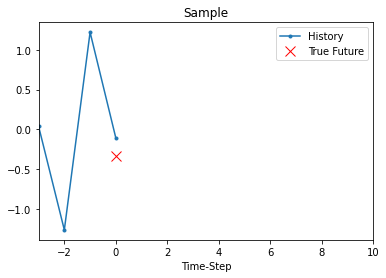

In [25]:
show_plot([x_train_single[0][0]  , y_train_single[0]], 0, 'Sample')

In [26]:
x_train_single.shape

(19712, 288, 4)

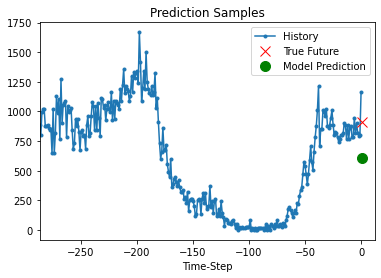

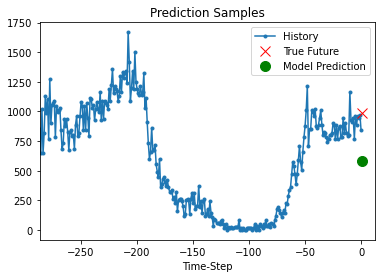

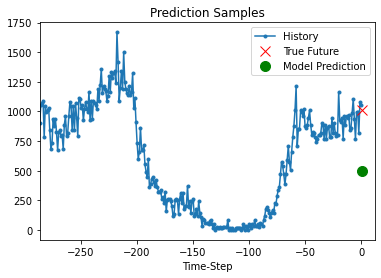

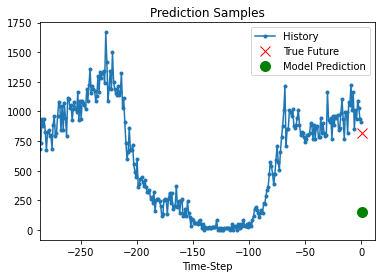

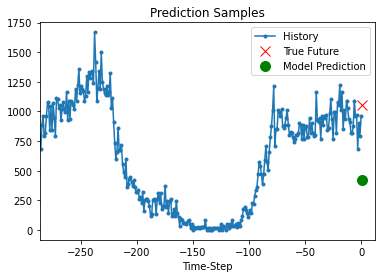

In [27]:
for x, y in val_data_single.take(5):
    x_val = x[0][:, 3].numpy()
    y_val = y[0].numpy()
    pred = single_step_model.predict(x)[0]
    
    plot = show_plot([denormalize_data(x_val, data_mean[3], data_std[3]),
                    denormalize_data(y_val, data_mean[3], data_std[3]),
                    denormalize_data(pred, data_mean[3], data_std[3])], 1,
                   'Prediction Samples')
    plot.show()

In [ ]:
EVALUATION_INTERVAL = 500
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch = x_train_single.shape[0],
                                            validation_data=val_data_single,
                                            validation_steps=x_val_single.shape[0])

Train for 19712 steps, validate for 5133 steps
Epoch 1/10
  421/19712 [..............................] - ETA: 28:36 - loss: 0.3610

In [28]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [ ]:
for x, y in val_data_single.take(5):
    x_val = x[0][:, 3].numpy()
    y_val = y[0].numpy()
    pred = single_step_model.predict(x)[0]
    
    plot = show_plot([denormalize_data(x_val, data_mean[3], data_std[3]),
                    denormalize_data(y_val, data_mean[3], data_std[3]),
                    denormalize_data(pred, data_mean[3], data_std[3])], 1,
                   'Prediction Samples')
    plot.show()